# Part 2: Transferability Attack
- Create your own substitute model for classification of Dog Breeds, and transfer adversarial samples to a corresponding model hosted by Clarifai. 
- This is a black-box attack, because we don’t have access to the model hosted by Clarifai.

In [ ]:
import sys;import cv2;import os
from os import listdir
import datetime;import pickle;import natsort
import numpy as np
import pandas as pd

from rich.console import Console
from rich.table import Table
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BoundaryAttack

print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

#np.random.seed(17)
#tf.compat.v1.set_random_seed(17)
#tf.random.set_seed(17)
#config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)
#tf.compat.v1.keras.backend.set_session(sess)
tf.compat.v1.disable_eager_execution()

In [2]:
NUM_CLASSES = 12
subset = 40  
DIM = 256
N_CHANNEL = 3   
INPUT_SHAPE = (DIM,DIM,N_CHANNEL)  
IMG_SHAPE = (DIM,DIM,N_CHANNEL)                                                
BATCH_SIZE = 4
NUM_EPOCH = 50                            
LR = 1e-5                                
RBW = True
PATIENCE = 7

In [3]:
def load_images(directory):
    imgs_list = []
    imgs_list_1 = listdir(directory)
    imagesList = natsort.natsorted(imgs_list_1)
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          img_arr = np.array(tmp_img)
          imgs_list.append(img_arr/255.)
    imgs = np.asarray(imgs_list)
    return imgs
all_images = load_images('C://data//data//Dataset_dog_breeds//Dataset_dog_breeds')

print('Shape of the images:', all_images.shape)
all_labels = np.loadtxt("C:/data/data/labels_dog_breeds.csv", delimiter=',').astype(int)
print('Shape of the labels:', all_labels.shape)

Shape of the images: (1961, 256, 256, 3)


In [8]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

In [9]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (1254, 256, 256, 3) - Labels train shape: (1254,)
Images validation shape: (314, 256, 256, 3) - Labels validation shape: (314,)
Images test shape: (393, 256, 256, 3) - Labels test shape: (393,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.44233429646671163
Data type float64


In [ ]:
#NUM_CLASSES = 12
#train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
#val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
#test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)


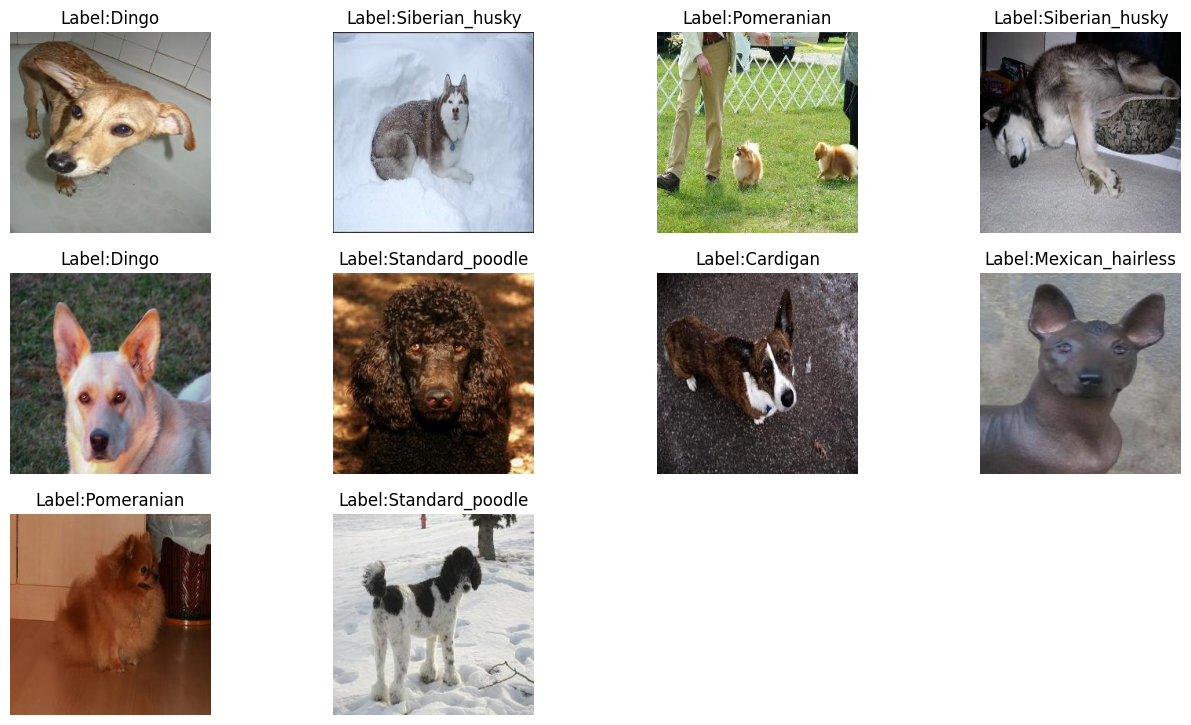

In [15]:
# A list with the names of the image classes
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', 
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 12))
for n in range(10):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(4, 4, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [16]:
def build_model0():
    base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=INPUT_SHAPE)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              #loss='categorical_crossentropy',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [17]:
callbacks = [EarlyStopping(monitor='val_loss',patience = PATIENCE,restore_best_weights=RBW),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience = PATIENCE,min_lr = 1e-7, verbose = 1)]

In [18]:
model = build_model0()

t = datetime.datetime.now()

history = model.fit(x= train_images,
    y= train_labels,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))


Instructions for updating:
Colocations handled automatically by placer.
Train on 1254 samples, validate on 314 samples
Epoch 1/50
1254/1254 [==============================] - ETA: 0s - loss: 2.2758 - accuracy: 0.2337

C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1254/1254 [==============================] - 51s 41ms/sample - loss: 2.2758 - accuracy: 0.2337 - val_loss: 2.6412 - val_accuracy: 0.0892 - lr: 1.0000e-05
Epoch 2/50
1254/1254 [==============================] - 42s 33ms/sample - loss: 1.4951 - accuracy: 0.5606 - val_loss: 2.4566 - val_accuracy: 0.1943 - lr: 1.0000e-05
Epoch 3/50
1254/1254 [==============================] - 42s 33ms/sample - loss: 0.9668 - accuracy: 0.7041 - val_loss: 0.7384 - val_accuracy: 0.7707 - lr: 1.0000e-05
Epoch 4/50
1254/1254 [==============================] - 42s 33ms/sample - loss: 0.6773 - accuracy: 0.7839 - val_loss: 0.4767 - val_accuracy: 0.8344 - lr: 1.0000e-05
Epoch 5/50
1254/1254 [==============================] - 42s 33ms/sample - loss: 0.5051 - accuracy: 0.8421 - val_loss: 0.4881 - val_accuracy: 0.8248 - lr: 1.0000e-05
Epoch 6/50
1254/1254 [==============================] - 42s 33ms/sample - loss: 0.3965 - accuracy: 0.8716 - val_loss: 0.4241 - val_accuracy: 0.8567 - lr: 1.0000e-05
Epoch 7/50
1254/1254 

In [21]:
#model.save('C://data//data//model//R50_doggers')
#np.save("C://data//data//model//R50_doggers_HistoryDict.npy", history.history)

INFO:tensorflow:Assets written to: C://data//data//model//R50_doggers/assets


INFO:tensorflow:Assets written to: C://data//data//model//R50_doggers/assets


In [23]:
model = load_model('C://data//data//model//R50_doggers')
history = np.load("C://data//data//model//R50_doggers_HistoryDict.npy",allow_pickle=True).item()

In [26]:
t = datetime.datetime.now()
evals_test = model.evaluate(test_images, test_labels)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))
eval_T = evals_test
t = datetime.datetime.now()
evals_test = model.evaluate(val_images, val_labels)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))
eval_V = evals_test
t = datetime.datetime.now()
evals_test = model.evaluate(train_images, train_labels)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))
eval_R = evals_test
R50_dog = pd.DataFrame(list(zip(eval_R,eval_V,eval_T)),columns = ["training","validate","test"])
R50_dog = R50_dog.drop(0)
R50_dog.to_pickle("part4")

C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Classification Accuracy Test:  0.8117048
Inference time: 0:00:04.742545 

Classification Accuracy Validation:  0.8566879
Inference time: 0:00:01.838145 

Classification Accuracy Train:  0.9864434
Inference time: 0:00:07.373339


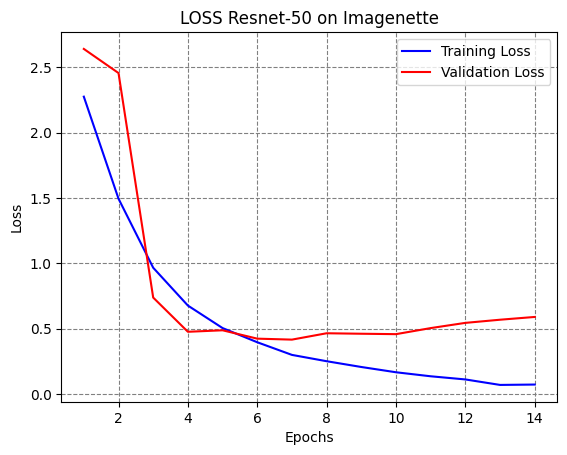

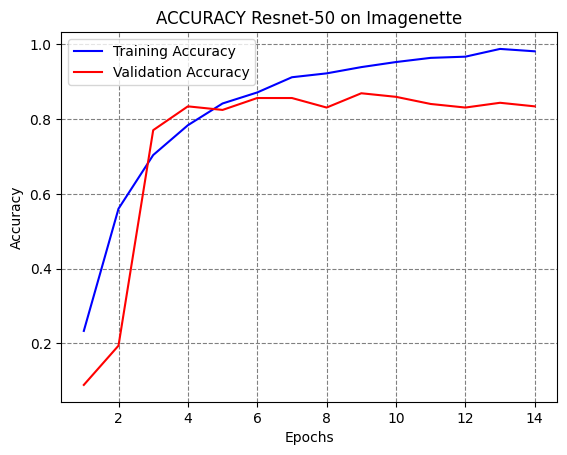

In [24]:
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS Resnet-50 on Imagenette')
plt.xlabel('Epochs')
plt.ylabel('Loss')

axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY Resnet-50 on Imagenette')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [27]:
part1 = pd.read_pickle("part4")
console = Console()
style = "bold blue"
table = Table('Part4 results:Dogs on Resnet-50')
table.add_row(part1.to_string(float_format=lambda _: '{:.2%}'.format(_)))
console.print(table)#,style = style)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Part4 results:Dogs on Resnet-50 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    training  validate   test    │
│ 1    98.64%    85.67% 81.17%    │
└─────────────────────────────────┘

## Task 2: Create adversarial samples against the Clarifai’s web ML model for dog breed classification.
- Step 1: Select one image from the test dataset to be used for creating adversarial samples. 
- Plot the image with the ground truth label and the predicted label by the DL model.
- https://clarifai.com/datastrategy/dog-breeds/models/dog-breeds-classifier

(256, 256, 3)
(1, 256, 256, 3)
Selected image is correctly classified by ResNet50 model


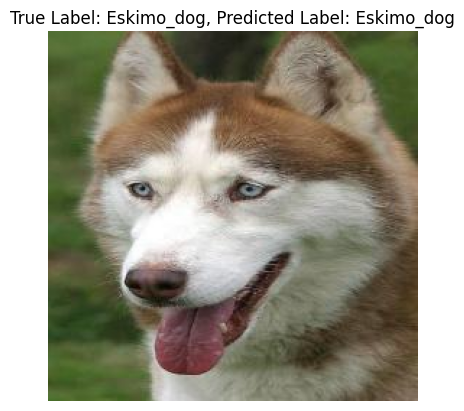

In [72]:
i = np.random.randint(0, len(test_images), 1)
image = test_images[i[0]]
print(image.shape)
label = test_labels[i[0]]
Img = image[np.newaxis, ...]
print(Img.shape)

output = model.predict(image[np.newaxis, ...])
predicted = np.argmax(output, axis=1)
if predicted == label:
    print("Selected image is correctly classified by ResNet50 model")
else:
    print("Selected image is misclassified by the ResNet50 model")
    
    
plt.imshow(test_images[i[0]])
plt.axis('off')
plt.title(f'True Label: {label_names[int(label)]}, Predicted Label: {label_names[int(predicted)]}')
plt.show()

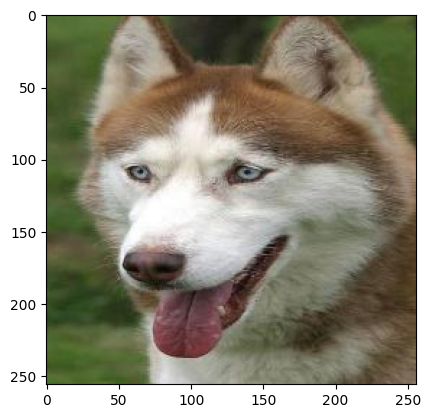

In [73]:
plt.imshow(image)

In [74]:
imageio.imwrite('intial.jpg',image)

![before PGD](before.jpg)

In [75]:
classifier = KerasClassifier(model = model,clip_values=(0, 1), use_logits=False)
attack_pgd = ProjectedGradientDescent(estimator = classifier, norm = np.inf, 
                                      eps = 0.1, eps_step = 0.01, max_iter = 200, 
                                      targeted = False, verbose = True)

adv_img = attack_pgd.generate(Img)
perturbation = np.mean(np.abs((adv_img - Img)))
print('Average perturbation: {:4.2f}'.format(perturbation))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Average perturbation: 0.06


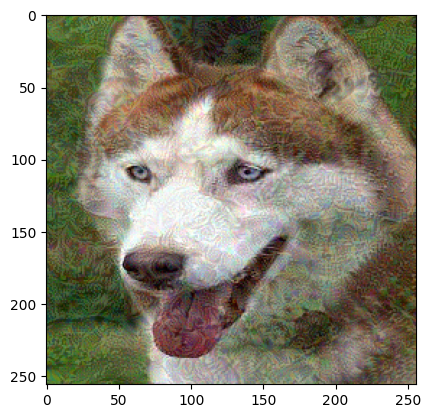

In [76]:
adv_img.shape
F = adv_img[0]
plt.imshow(F)
imageio.imwrite('PGD.jpg',F)

![Post PGD](after.jpg)